In [11]:
try:
    import torch
    import torchvision
    assert int(torch.__vision__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cull3
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cull3
torch version: 2.5.1+cu118
torchvision version: 0.20.1+cu118


In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo...installing")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_Data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going _modular or helper function...downloading via github")
    # !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # !mv pytorch-deep-learning/going_modular .
    # !mv pytorch-deep-learning/helper_functions.py .
    # !rm -rf pytorch-deep-learning
    # from going_modular.going_modular import data_setup, engine
    # from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find going _modular or helper function...downloading via github


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [26]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [27]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# TRAIN a EffNetBS (Model 1) and ViT (Model 2)

In [50]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Load the pre-trained EfficientNet-B2 weights
effnetb2_weights = EfficientNet_B2_Weights.DEFAULT

# Get the transform for the pre-trained weights
effnetb2_transform = effnetb2_weights.transforms()

# Example: Print the transform pipeline
print(effnetb2_transform)

# Load the EfficientNet-B2 model with pre-trained weights
effnetb2 = efficientnet_b2(weights=effnetb2_weights)

# freeze base layer
for param in effnetb2.parameters():
    param.requires_grad = False

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [40]:
from torchinfo import summary

In [41]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [45]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))

In [46]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [65]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    weights = EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = efficientnet_b2(weights=weights)

    for param in effnetb2.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [ ]:
# def create_effnetb2_model(num_classes: int = 3,
#                           seed: int = 42):
#     # Load pre-trained weights and default transforms
#     weights = EfficientNet_B2_Weights.DEFAULT
#     base_transforms = weights.transforms()

#     # Augmentation for training
#     train_transforms = transforms.Compose([
#         transforms.RandomResizedCrop(288),  # Random crop and resize
#         transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness/contrast/saturation
#         transforms.RandomRotation(15),  # Rotate by 15 degrees
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     # Testing (or validation) transforms: same as base transforms
#     test_transforms = base_transforms

#     # Load pre-trained EfficientNet-B2 model
#     model = efficientnet_b2(weights=weights)

#     # Freeze feature extractor
#     for param in model.features.parameters():
#         param.requires_grad = False

#     # Set seed for reproducibility
#     torch.manual_seed(seed)

#     # Modify the classifier for the specified number of output classes
#     model.classifier = nn.Sequential(
#         nn.Dropout(p=0.3, inplace=True),  # Dropout for regularization
#         nn.Linear(in_features=1408, out_features=num_classes)  # Custom classification layer
#     )

#     # Return model and transforms as a dictionary (for flexibility)
#     return model, {"train": train_transforms, "test": test_transforms}


In [68]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

In [ ]:
#data loaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [71]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001,
                             weight_decay=0.00001)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:57<08:37, 57.55s/it]

Epoch: 1 | train_loss: 0.0438 | train_acc: 0.9854 | test_loss: 0.1379 | test_acc: 0.9625


 20%|██        | 2/10 [01:54<07:36, 57.02s/it]

Epoch: 2 | train_loss: 0.0801 | train_acc: 0.9729 | test_loss: 0.1177 | test_acc: 0.9631


 30%|███       | 3/10 [02:52<06:42, 57.56s/it]

Epoch: 3 | train_loss: 0.0378 | train_acc: 0.9875 | test_loss: 0.1615 | test_acc: 0.9500


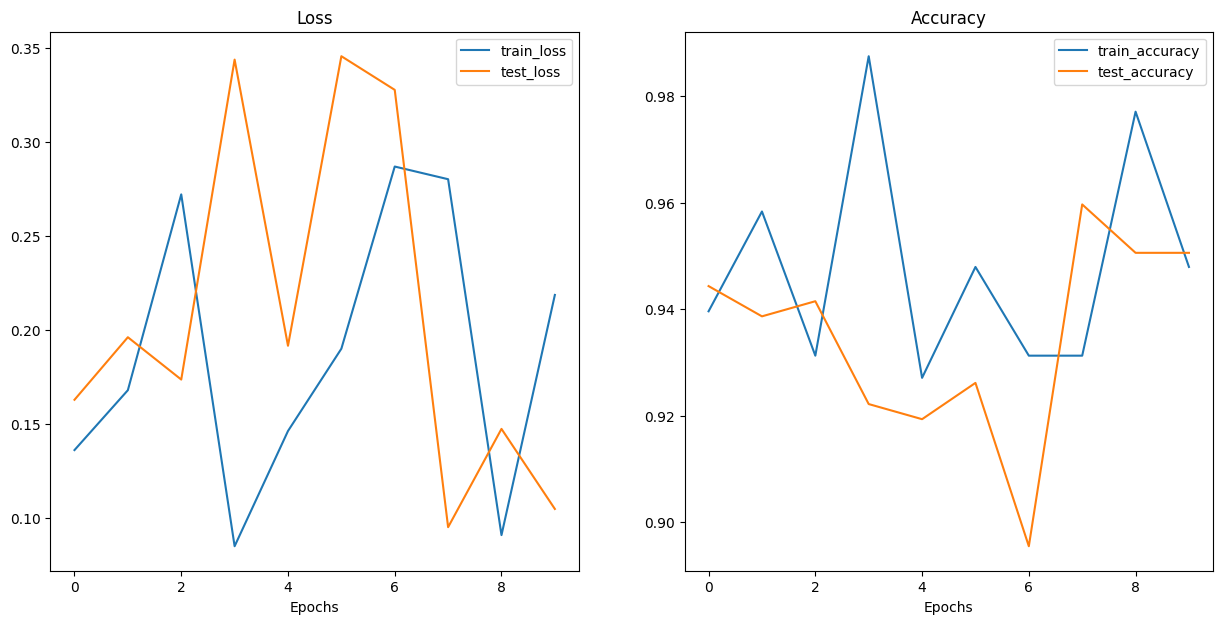

In [78]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)